In [79]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [80]:
# load data
df = pd.read_csv('../../data/H2.csv')

1. Split train and test data

In [81]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.shape, test_df.shape

((63464, 31), (15866, 31))

2. Handle Missing Values

In [82]:
# Handle missing values
train_df['Children'].fillna(0, inplace=True)  # Fill missing 'Children' with 0
train_df['Country'].fillna('Unknown', inplace=True)  # Fill missing 'Country' with 'Unknown'

# Drop rows where adults, babies and children are zero at the same time
train_df = train_df[(train_df['Adults'] != 0) | (train_df['Babies'] != 0) | (train_df['Children'] != 0)] 

3. Remove Outliers

In [83]:
# Get only numerical data
train_df_num = train_df.select_dtypes(include=[np.number])
# Get only Categorical data
train_df_cat = train_df.select_dtypes(include=['object'])

train_df_num.shape, train_df_cat.shape

((63335, 18), (63335, 13))

In [84]:
train_df_num.nunique().sort_values()

IsCanceled                        2
IsRepeatedGuest                   2
ArrivalDateYear                   3
Children                          4
Babies                            4
RequiredCarParkingSpaces          4
Adults                            5
TotalOfSpecialRequests            6
PreviousCancellations            10
StaysInWeekendNights             11
BookingChanges                   17
StaysInWeekNights                25
ArrivalDateDayOfMonth            31
ArrivalDateWeekNumber            53
PreviousBookingsNotCanceled      64
DaysInWaitingList               113
LeadTime                        451
ADR                            4837
dtype: int64

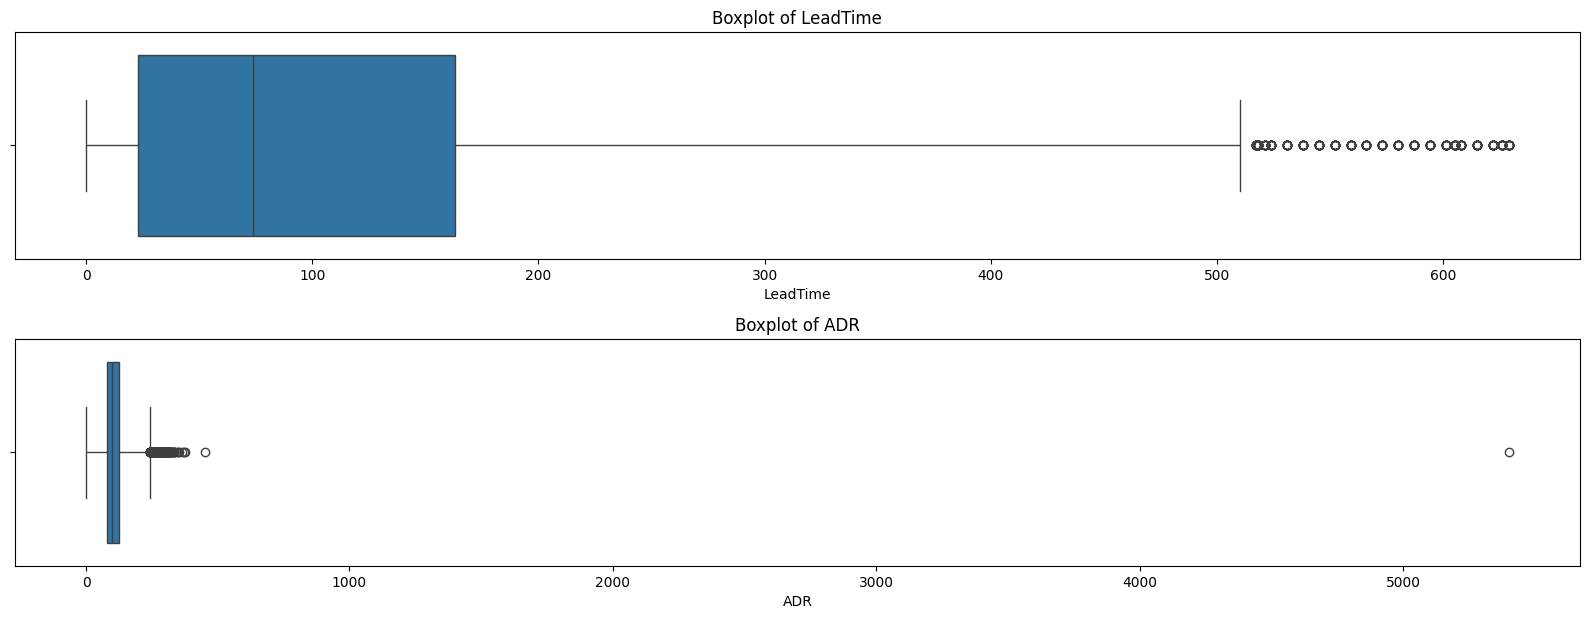

In [85]:
train_df_num_out= train_df_num[
    [
        "LeadTime",
        "ADR",
    ]
]

# Boxplot
plt.figure(figsize=(16, 12))
for i, col in enumerate(train_df_num_out, 1):
    plt.subplot(4, 1, i)
    sns.boxplot(data=train_df, x=col, whis=2.5)
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [86]:
# Outlier Detection Fonksion
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]


# Outlier Analysis
outlier_summary = {}

for col in train_df_num_out:
    outliers = detect_outliers_iqr(train_df, col)
    outlier_summary[col] = len(outliers)
    print(f"{col}: {len(outliers)} outliers detected.")

# Özet sonucu yazdır
print("Outlier counts per column:", outlier_summary)

LeadTime: 306 outliers detected.
ADR: 363 outliers detected.
Outlier counts per column: {'LeadTime': 306, 'ADR': 363}


In [87]:
# Remove Outliers
def remove_outliers(data, outliers):
  return data.drop(outliers.index)

for col in train_df_num_out:
  outliers = detect_outliers_iqr(train_df, col)
  train_df = remove_outliers(train_df, outliers)
  print(f"{col}: {len(outliers)} outliers removed.")

LeadTime: 306 outliers removed.
ADR: 370 outliers removed.


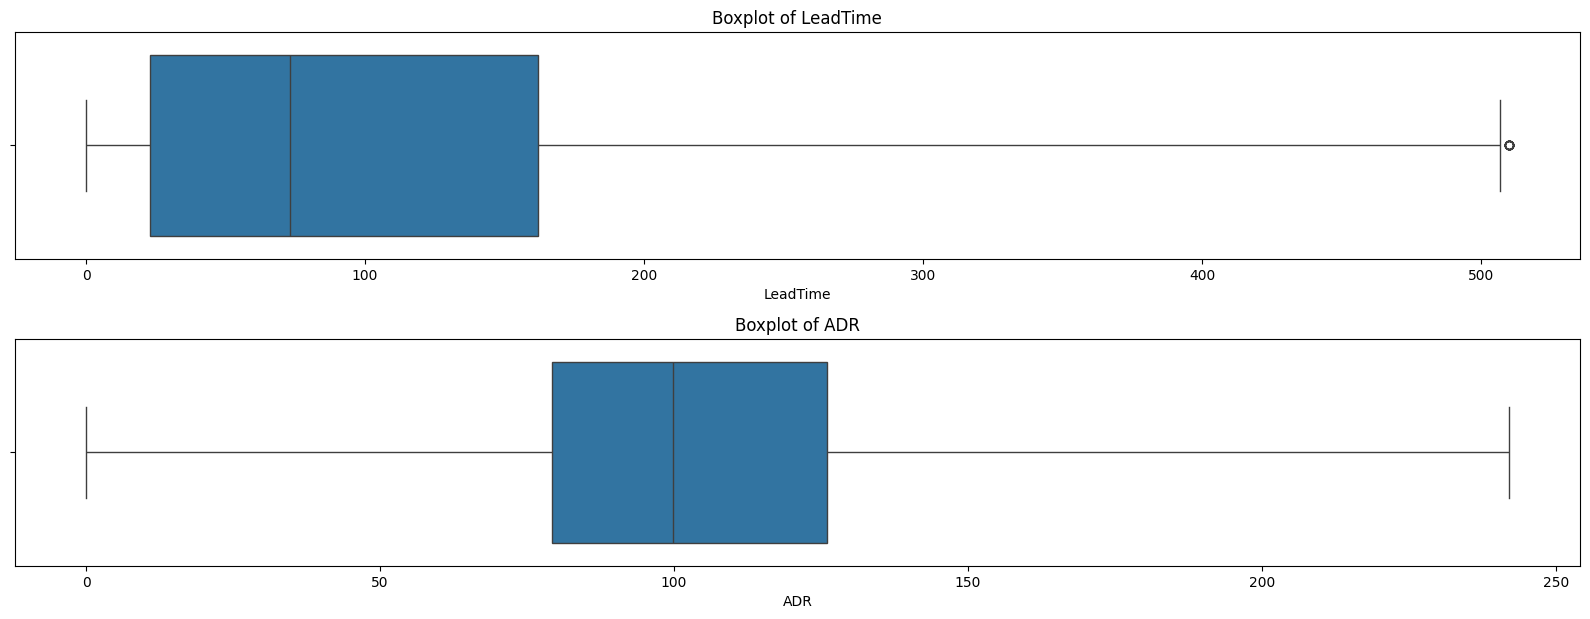

In [88]:
# Boxplot
plt.figure(figsize=(16, 12))
for i, col in enumerate(train_df_num_out, 1):
    plt.subplot(4, 1, i)
    sns.boxplot(data=train_df, x=col, whis=2.5)
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [101]:
train_df.shape

(62659, 33)

4. Feature Selection and Creation

In [89]:
# Columns to drop from the dataset
columns_to_drop = [
    'IsCanceled', 
    'ReservationStatus', 
    'ReservationStatusDate', 
    'ArrivalDateYear', 
    'ArrivalDateMonth', 
    'ArrivalDateWeekNumber', 
    'ArrivalDateDayOfMonth', 
    'Company'
]

# Drop the specified columns
train_df = train_df.drop(columns=columns_to_drop)

In [90]:
# TotalStay: Total number of nights the customer stayed
train_df["TotalStay"] = train_df["StaysInWeekendNights"] + train_df["StaysInWeekNights"]

# SpendingPerPerson: Customer's spending capacity per person
train_df["SpendingPerPerson"] = train_df["ADR"] / (train_df["Adults"] + train_df["Children"] + train_df["Babies"])
train_df["SpendingPerPerson"].fillna(0, inplace=True)  # Handle division by zero


# GroupType: Structure of customer groups
def determine_group_type(row):
    if row["Adults"] == 1 and (row["Children"] + row["Babies"] == 0):
        return "Single"
    elif row["Adults"] == 2 and (row["Children"] + row["Babies"] == 0):
        return "Couple"
    elif (row["Children"] + row["Babies"]) > 0:
        return "Family"
    elif row["Adults"] > 2:
        return "Big_Group"
    else:
        return "Other"


train_df["GroupType"] = train_df.apply(determine_group_type, axis=1)


# BookingUrgency: Categorize bookings by lead time
def determine_booking_urgency(lead_time):
    if lead_time > 60:
        return "Early_Booking"
    elif 30 <= lead_time <= 60:
        return "Medium_Term_Booking"
    else:
        return "Last_Minute_Booking"


train_df["BookingUrgency"] = train_df["LeadTime"].apply(determine_booking_urgency)

# HighDemand: Categorize customers based on special requests
train_df["HighDemand"] = train_df["TotalOfSpecialRequests"].apply(
    lambda x: "High" if x >= 2 else "Low"
)

# LoyaltyScore: Numerical representation of customer loyalty
train_df["LoyaltyScore"] = train_df["IsRepeatedGuest"] * (train_df["PreviousBookingsNotCanceled"] + 1)

# ChildRatio: Ratio of children to total group size
train_df["ChildRatio"] = (train_df["Children"] + train_df["Babies"]) / (
    train_df["Adults"] + train_df["Children"] + train_df["Babies"]
)
train_df["ChildRatio"].fillna(0, inplace=True)  # Handle division by zero

# Occupancy: Density and occupancy rate of rooms
train_df["Occupancy"] = (train_df["Adults"] + train_df["Children"] + train_df["Babies"]) / train_df["TotalStay"]
train_df["Occupancy"].fillna(0, inplace=True)  # Handle division by zero


# WaitingTimeCategory: Categorize customers based on waiting time
def determine_waiting_time_category(days):
    if days < 7:
        return "Short"
    elif 7 <= days <= 30:
        return "Medium"
    else:
        return "Long"


train_df["WaitingTimeCategory"] = train_df["DaysInWaitingList"].apply(
    determine_waiting_time_category
)

# CancellationRisk: Risk score based on previous cancellations and lead time
train_df["CancellationRisk"] = train_df["PreviousCancellations"] * train_df["LeadTime"]

In [91]:
train_df.shape, train_df.columns

((62659, 33),
 Index(['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults',
        'Children', 'Babies', 'Meal', 'Country', 'MarketSegment',
        'DistributionChannel', 'IsRepeatedGuest', 'PreviousCancellations',
        'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
        'BookingChanges', 'DepositType', 'Agent', 'DaysInWaitingList',
        'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
        'TotalOfSpecialRequests', 'TotalStay', 'SpendingPerPerson', 'GroupType',
        'BookingUrgency', 'HighDemand', 'LoyaltyScore', 'ChildRatio',
        'Occupancy', 'WaitingTimeCategory', 'CancellationRisk'],
       dtype='object'))

Since the `Country` Column, which contains country codes, contains too many categories, let's reduce it to regions.

In [92]:
# Define a dictionary to map country codes to regions
country_to_region = {
    "PRT": "Europe",
    "GBR": "Europe",
    "ESP": "Europe",
    "IRL": "Europe",
    "NLD": "Europe",
    "RUS": "Europe",
    "FRA": "Europe",
    "DEU": "Europe",
    "ITA": "Europe",
    "BEL": "Europe",
    "CHE": "Europe",
    "USA": "North America",
    "CAN": "North America",
    "MEX": "North America",
    "CN": "Asia",
    "BRA": "South America",
    "ARG": "South America",
    "AUS": "Oceania",
    "Unknown": "Unknown",
}

# Map the country codes to regions
train_df["Region"] = train_df["Country"].map(country_to_region)

# Drop the Country column
train_df.drop(columns=["Country"], inplace=True)

train_df["Region"].value_counts()

Region
Europe           51735
South America     1572
North America     1336
Asia               448
Oceania            253
Unknown             13
Name: count, dtype: int64

The categorical variable `Agent` has a lot of unique values ​​and most of them are numbers. There is only one string named 'NULL'. And some reason there is blank spaces before values.
- There is blanks in data, first we will remove these.
- We can change the 'NULL' value of this variable to 0 and
- convert it to int to make it easier to deal with.

In [93]:
# Remove blank spaces from the 'Agent' column
train_df['Agent'] = train_df['Agent'].str.strip()

# Replace 'NULL' values in the 'Agent' column with 0
train_df['Agent'].replace('NULL', 0, inplace=True)

# Convert the 'Agent' column to integer
train_df['Agent'] = train_df['Agent'].astype(int)

5. Encoding and Scaling

In [94]:
# Get only numerical data
train_df_num = train_df.select_dtypes(include=[np.number])
# Get only Categorical data
train_df_cat = train_df.select_dtypes(include=['object'])

train_df_num.shape, train_df_cat.shape

((62659, 21), (62659, 12))

In [95]:
# Numerical columns with unique values 
train_df_num.nunique().sort_values()

IsRepeatedGuest                   2
Children                          4
Babies                            4
RequiredCarParkingSpaces          4
Adults                            5
TotalOfSpecialRequests            6
PreviousCancellations            10
ChildRatio                       10
StaysInWeekendNights             11
BookingChanges                   17
StaysInWeekNights                25
TotalStay                        33
PreviousBookingsNotCanceled      64
LoyaltyScore                     65
Occupancy                        71
DaysInWaitingList               113
Agent                           218
CancellationRisk                284
LeadTime                        430
ADR                            4672
SpendingPerPerson              5780
dtype: int64

In [96]:
train_df_cat.nunique().sort_values()

HighDemand             2
DepositType            3
BookingUrgency         3
WaitingTimeCategory    3
CustomerType           4
Meal                   4
GroupType              4
DistributionChannel    5
Region                 6
ReservedRoomType       7
AssignedRoomType       8
MarketSegment          8
dtype: int64

**One-Hot Encode**<br>

***Numeric columns that behave like Categorical***
- `IsRepeatedGuest`, 
- `PreviousCancellations`, 
- `RequiredCarParkingSpaces`, 
- `Babies`, 
- `Children`, 
- `LoyaltyScore`, 
- `Adults`, 
- `TotalOfSpecialRequests`, 
- `ChildRatio`, 
- `StaysInWeekendNights`<br>
***Categorical Columns***
- `HighDemand`
- `DepositType`
- `BookingUrgency`
- `WaitingTimeCategory`
- `CustomerType`
- `Meal`
- `GroupType`
- `DistributionChannel`
- `Region`
- `ReservedRoomType`
- `AssignedRoomType`
- `MarketSegment`

***StandarScaler***
- `BookingChanges`
- `StaysInWeekNights`
- `TotalStay`
- `PreviousBookingsNotCanceled`
- `Occupancy`
- `DaysInWaitingList`
- `Agent`
- `CancellationRisk`
- `LeadTime`
- `ADR`
- `SpendingPerPerson`

In [97]:
from sklearn.preprocessing import OneHotEncoder

# One Hot Encoding - Categorical Variables
cat_encoder = OneHotEncoder()
train_cat_1hot = cat_encoder.fit_transform(train_df_cat)
train_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 751908 stored elements and shape (62659, 58)>

In [98]:
train_cat_1hot_dense = train_cat_1hot.toarray()
encoded_cat_df = pd.DataFrame(train_cat_1hot_dense, 
                          columns=cat_encoder.get_feature_names_out(train_df_cat.columns))

encoded_cat_df

,Meal_BB,Meal_FB,Meal_HB,Meal_SC,MarketSegment_Aviation,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,MarketSegment_Undefined,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_GDS,DistributionChannel_TA/TO,DistributionChannel_Undefined,ReservedRoomType_A,ReservedRoomType_B,ReservedRoomType_C,ReservedRoomType_D,ReservedRoomType_E,ReservedRoomType_F,ReservedRoomType_G,AssignedRoomType_A,AssignedRoomType_B,AssignedRoomType_C,AssignedRoomType_D,AssignedRoomType_E,AssignedRoomType_F,AssignedRoomType_G,AssignedRoomType_K,DepositType_No Deposit,DepositType_Non Refund,DepositType_Refundable,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,GroupType_Big_Group,GroupType_Couple,GroupType_Family,GroupType_Single,BookingUrgency_Early_Booking,BookingUrgency_Last_Minute_Booking,BookingUrgency_Medium_Term_Booking,HighDemand_High,HighDemand_Low,WaitingTimeCategory_Long,WaitingTimeCategory_Medium,WaitingTimeCategory_Short,Region_Asia,Region_Europe,Region_North America,Region_Oceania,Region_South America,Region_Unknown,Region_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62654,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
62655,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
62656,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
62657,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [99]:
# One Hot Encoding - Numeric columns that behave like Categorical
encode_numeric = ['IsRepeatedGuest', 'PreviousCancellations', 'RequiredCarParkingSpaces', 'Babies',
                  'Children', 'LoyaltyScore', 'Adults', 'TotalOfSpecialRequests', 'ChildRatio', 'StaysInWeekendNights']

num_encoder = OneHotEncoder()

train_num_1hot = num_encoder.fit_transform(train_df_num[encode_numeric])
train_num_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 626590 stored elements and shape (62659, 121)>

In [100]:
train_num_1hot_dense = train_num_1hot.toarray()
encoded_num_df = pd.DataFrame(
    train_num_1hot_dense, columns=num_encoder.get_feature_names_out(train_df_num[encode_numeric].columns)
)

encoded_num_df

,IsRepeatedGuest_0,IsRepeatedGuest_1,PreviousCancellations_0,PreviousCancellations_1,PreviousCancellations_2,PreviousCancellations_3,PreviousCancellations_4,PreviousCancellations_5,PreviousCancellations_6,PreviousCancellations_11,PreviousCancellations_13,PreviousCancellations_21,RequiredCarParkingSpaces_0,RequiredCarParkingSpaces_1,RequiredCarParkingSpaces_2,RequiredCarParkingSpaces_3,Babies_0,Babies_1,Babies_2,Babies_9,Children_0.0,Children_1.0,Children_2.0,Children_3.0,LoyaltyScore_0,LoyaltyScore_1,LoyaltyScore_2,LoyaltyScore_3,LoyaltyScore_4,LoyaltyScore_5,LoyaltyScore_6,LoyaltyScore_7,LoyaltyScore_8,LoyaltyScore_9,LoyaltyScore_10,LoyaltyScore_11,LoyaltyScore_12,LoyaltyScore_13,LoyaltyScore_14,LoyaltyScore_15,LoyaltyScore_16,LoyaltyScore_17,LoyaltyScore_18,LoyaltyScore_19,LoyaltyScore_20,LoyaltyScore_21,LoyaltyScore_22,LoyaltyScore_23,LoyaltyScore_24,LoyaltyScore_25,LoyaltyScore_26,LoyaltyScore_27,LoyaltyScore_28,LoyaltyScore_29,LoyaltyScore_30,LoyaltyScore_31,LoyaltyScore_32,LoyaltyScore_36,LoyaltyScore_37,LoyaltyScore_38,LoyaltyScore_39,LoyaltyScore_40,LoyaltyScore_41,LoyaltyScore_42,LoyaltyScore_43,LoyaltyScore_44,LoyaltyScore_45,LoyaltyScore_46,LoyaltyScore_47,LoyaltyScore_48,LoyaltyScore_49,LoyaltyScore_51,LoyaltyScore_52,LoyaltyScore_54,LoyaltyScore_55,LoyaltyScore_57,LoyaltyScore_58,LoyaltyScore_59,LoyaltyScore_60,LoyaltyScore_61,LoyaltyScore_62,LoyaltyScore_63,LoyaltyScore_64,LoyaltyScore_67,LoyaltyScore_69,LoyaltyScore_70,LoyaltyScore_71,LoyaltyScore_72,LoyaltyScore_73,Adults_0,Adults_1,Adults_2,Adults_3,Adults_4,TotalOfSpecialRequests_0,TotalOfSpecialRequests_1,TotalOfSpecialRequests_2,TotalOfSpecialRequests_3,TotalOfSpecialRequests_4,TotalOfSpecialRequests_5,ChildRatio_0.0,ChildRatio_0.25,ChildRatio_0.3333333333333333,ChildRatio_0.4,ChildRatio_0.5,ChildRatio_0.6,ChildRatio_0.6666666666666666,ChildRatio_0.75,ChildRatio_0.9,ChildRatio_1.0,StaysInWeekendNights_0,StaysInWeekendNights_1,StaysInWeekendNights_2,StaysInWeekendNights_3,StaysInWeekendNights_4,StaysInWeekendNights_5,StaysInWeekendNights_6,StaysInWeekendNights_7,StaysInWeekendNights_8,StaysInWeekendNights_9,StaysInWeekendNights_10
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0

This is the end of the encoding process, when we apply StandardScale to the remaining numeric columns, the data is ready for ML.